This notebook shows the yelp dataset start rating classification problem.
The objective is to predict the star rating based on the:
- business review count
- total number of checkins
- state where business is located
- city where business is located

In [53]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

np.random.seed(42)


## 1. Load Data

In [54]:
df_business = pd.read_json('../../data/business.json',lines=True)
df_checkin = pd.read_json('../../data/checkin.json', lines=True)

## 2. Exploratory Data Analysis (EDA)

In [55]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
address         192609 non-null object
attributes      163773 non-null object
business_id     192609 non-null object
categories      192127 non-null object
city            192609 non-null object
hours           147779 non-null object
is_open         192609 non-null int64
latitude        192609 non-null float64
longitude       192609 non-null float64
name            192609 non-null object
postal_code     192609 non-null object
review_count    192609 non-null int64
stars           192609 non-null float64
state           192609 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


In [56]:
df_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522,-112.018,Arizona Biltmore Golf Club,85016,5,3.000,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605,-79.652,Emerald Chinese Restaurant,L5R 3E7,128,2.500,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.093,-80.859,Musashi Japanese Restaurant,28210,170,4.000,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.456,-112.396,Farmers Insurance - Paul Lorenz,85338,3,5.000,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190,-80.887,Queen City Plumbing,28217,4,4.000,NC


In [57]:
df_business.shape

(192609, 14)

In [58]:
total = df_business.isnull().sum().sort_values(ascending=False)
percent = (df_business.isnull().sum()/df_business.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data

,Total,Percent
hours,44830,0.303
attributes,28836,0.176
categories,482,0.003
state,0,0.000
stars,0,0.000
review_count,0,0.000
postal_code,0,0.000
name,0,0.000
longitude,0,0.000
latitude,0,0.000


In [59]:
df_business.dropna(inplace=True)

In [60]:
df_business.shape

(129268, 14)

In [61]:
df_business['review_count'].describe()

count   129268.000
mean        44.508
std        131.780
min          3.000
25%          6.000
50%         13.000
75%         36.000
max       8348.000
Name: review_count, dtype: float64

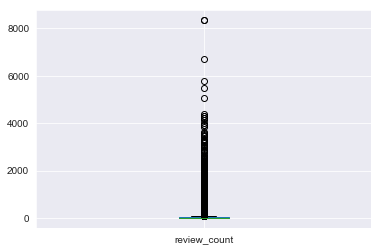

In [62]:
df_business[['review_count']].boxplot()
pyplot.show()

In [63]:
df_business['review_count'] = df_business['review_count'].fillna(0)

In [64]:
df_business['stars'] = round(df_business['stars'].fillna(0)).apply(int)

In [65]:
list_starts = df_business['stars'].unique()
list_starts

array([2, 4, 5, 3, 1])

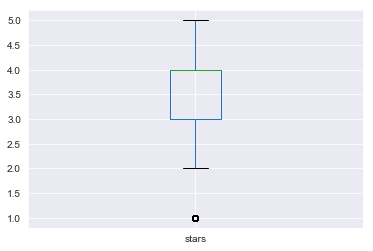

In [66]:
df_business[['stars']].boxplot()
pyplot.show()

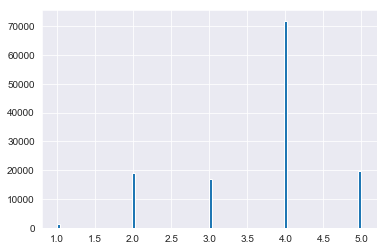

In [67]:
plt.hist(df_business['stars'].tolist(), bins='auto')  
plt.show()

In [68]:
df_business.describe()

,is_open,latitude,longitude,review_count,stars
count,129268.000,129268.000,129268.000,129268.000,129268.000
mean,0.844,38.348,-97.977,44.508,3.693
std,0.363,4.868,16.626,131.780,0.939
min,0.000,33.205,-115.478,3.000,1.000
25%,1.000,33.626,-112.273,6.000,3.000
50%,1.000,36.128,-111.791,13.000,4.000
75%,1.000,43.113,-80.037,36.000,4.000
max,1.000,51.297,-72.945,8348.000,5.000


In [69]:
df_business['stars'].describe()

count   129268.000
mean         3.693
std          0.939
min          1.000
25%          3.000
50%          4.000
75%          4.000
max          5.000
Name: stars, dtype: float64

In [70]:
stars = df_business.groupby('stars').mean()

In [71]:
stars.corr()

,is_open,latitude,longitude,review_count
is_open,1.000,-0.911,-0.911,-0.652
latitude,-0.911,1.000,0.999,0.449
longitude,-0.911,0.999,1.000,0.437
review_count,-0.652,0.449,0.437,1.000


In [72]:
numeric_features = df_business.loc[:, ['latitude', 'longitude', 'review_count', 'stars']]

In [73]:
numeric_features_standardized = (numeric_features)/numeric_features.max()

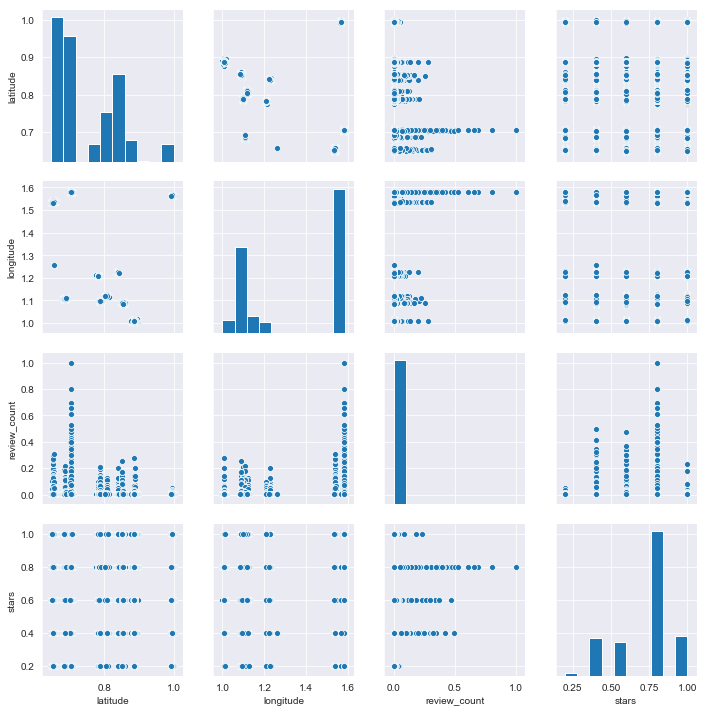

In [74]:
ax = sns.pairplot(numeric_features_standardized)
plt.show()

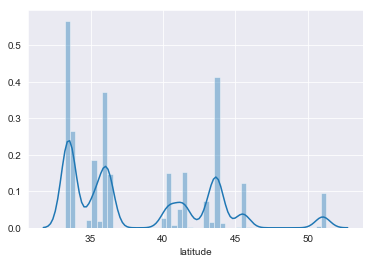

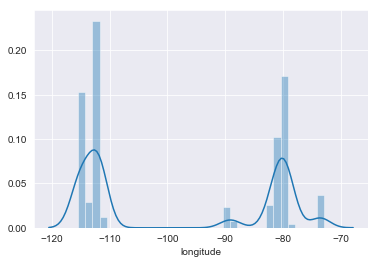

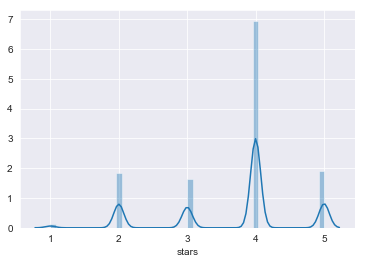

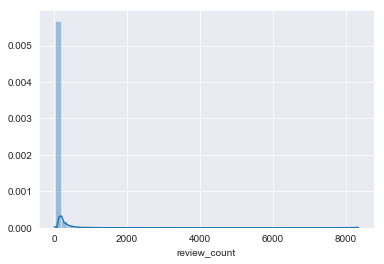

In [75]:
ax = sns.distplot(df_business['latitude'])
plt.show()
ax = sns.distplot(df_business['longitude'])
plt.show()
ax = sns.distplot(df_business['stars'])
plt.show()
ax = sns.distplot(df_business['review_count'])
plt.show()

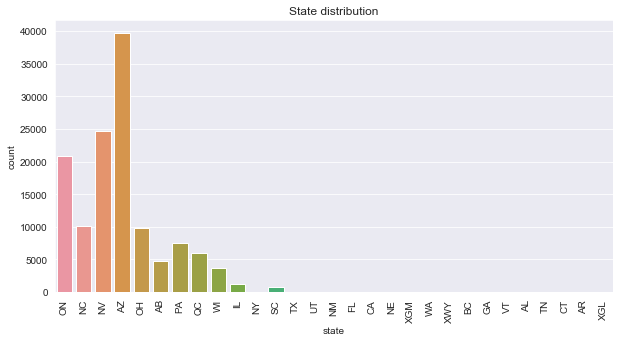

In [76]:
plt.figure(figsize=(10,5))
sns.countplot(x='state', data=df_business)
plt.xticks(rotation='vertical')
plt.title('State distribution')
plt.show()

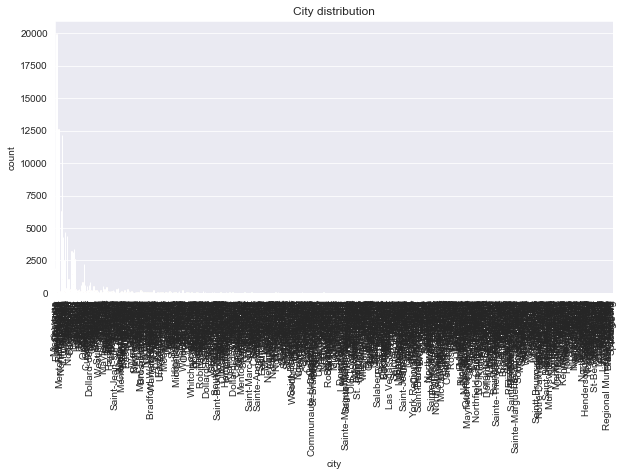

In [77]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='city', data=df_business)
plt.xticks(rotation='vertical')
plt.title('City distribution')
plt.show()

In [78]:
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161950 entries, 0 to 161949
Data columns (total 2 columns):
business_id    161950 non-null object
date           161950 non-null object
dtypes: object(2)
memory usage: 2.5+ MB


In [79]:
df_checkin.head()

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."


In [80]:
df_checkin.shape

(161950, 2)

In [81]:
#from datetime import datetime
#datetime_object = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [82]:
def get_checkin_count(x):
    return len(x.split(", "))

df_checkin['checkin_count'] = df_checkin['date'].apply(get_checkin_count)

In [83]:
df_checkin.head()

,business_id,date,checkin_count
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016...",6
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012...",167
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015...",180
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30,1
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010...",37


In [84]:
len(df_checkin["checkin_count"].unique())

2884

## 3. Prepare Data

In [85]:
df_merged = pd.merge(df_business, df_checkin, on='business_id', how='left')

In [86]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 16 columns):
address          129268 non-null object
attributes       129268 non-null object
business_id      129268 non-null object
categories       129268 non-null object
city             129268 non-null object
hours            129268 non-null object
is_open          129268 non-null int64
latitude         129268 non-null float64
longitude        129268 non-null float64
name             129268 non-null object
postal_code      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null int64
state            129268 non-null object
date             113701 non-null object
checkin_count    113701 non-null float64
dtypes: float64(3), int64(3), object(10)
memory usage: 16.8+ MB


In [87]:
df_merged.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,date,checkin_count
0,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605,-79.652,Emerald Chinese Restaurant,L5R 3E7,128,2,ON,"2010-07-05 16:56:31, 2010-12-21 20:30:01, 2010...",455.000
1,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.093,-80.859,Musashi Japanese Restaurant,28210,170,4,NC,"2010-11-13 01:00:36, 2010-12-19 00:49:15, 2011...",721.000
2,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190,-80.887,Queen City Plumbing,28217,4,4,NC,NaN,nan
3,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599,-79.712,The UPS Store,L5V 0B1,3,2,ON,"2014-03-31 21:46:17, 2015-01-27 19:05:03, 2018...",3.000
4,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.100,-115.075,Supercuts,89121,3,4,NV,"2011-05-21 22:20:31, 2011-10-05 21:34:47, 2012...",11.000


In [88]:
df_merged.shape

(129268, 16)

In [89]:
df_merged[['checkin_count']] = df_merged[['checkin_count']].fillna(0)

In [90]:
df_merged.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,date,checkin_count
0,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605,-79.652,Emerald Chinese Restaurant,L5R 3E7,128,2,ON,"2010-07-05 16:56:31, 2010-12-21 20:30:01, 2010...",455.000
1,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.093,-80.859,Musashi Japanese Restaurant,28210,170,4,NC,"2010-11-13 01:00:36, 2010-12-19 00:49:15, 2011...",721.000
2,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190,-80.887,Queen City Plumbing,28217,4,4,NC,NaN,0.000
3,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599,-79.712,The UPS Store,L5V 0B1,3,2,ON,"2014-03-31 21:46:17, 2015-01-27 19:05:03, 2018...",3.000
4,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.100,-115.075,Supercuts,89121,3,4,NV,"2011-05-21 22:20:31, 2011-10-05 21:34:47, 2012...",11.000


In [91]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 16 columns):
address          129268 non-null object
attributes       129268 non-null object
business_id      129268 non-null object
categories       129268 non-null object
city             129268 non-null object
hours            129268 non-null object
is_open          129268 non-null int64
latitude         129268 non-null float64
longitude        129268 non-null float64
name             129268 non-null object
postal_code      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null int64
state            129268 non-null object
date             113701 non-null object
checkin_count    129268 non-null float64
dtypes: float64(3), int64(3), object(10)
memory usage: 16.8+ MB


In [92]:
df_merged_new = df_merged[['business_id','review_count', 'stars', 'checkin_count', 'city', 'state', 'categories']]
df_merged_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 7 columns):
business_id      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null int64
checkin_count    129268 non-null float64
city             129268 non-null object
state            129268 non-null object
categories       129268 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 7.9+ MB


In [93]:
df_merged_new['stars'] = df_merged_new['stars'].round()

In [94]:
df_merged_new['stars'].value_counts()

4    71892
5    19854
2    19047
3    17020
1     1455
Name: stars, dtype: int64

In [95]:
df_merged_new['review_count'] = df_merged_new['review_count'].fillna(0)

## 4. Train Models

- #### Normalize numeric features

In [96]:
from sklearn.preprocessing import StandardScaler

cols_to_norm = ['review_count', 'checkin_count']
#new_df[cols_to_norm] = new_df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

dict_scaler = {}
for col_to_norm in cols_to_norm:
    #scaler = StandardScaler()
    #scaler.fit(df_merged_new.loc[:, col_to_norm].values.reshape(-1, 1))
    #dict_scaler[col_to_norm] = scaler 
    #df_merged_new.loc[:,col_to_norm] = scaler.transform(df_merged_new.loc[:,col_to_norm].values.reshape(-1, 1))
    
    df_merged_new[cols_to_norm] = df_merged_new[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
     

- #### Transform features of types string to integer

In [97]:
from sklearn import preprocessing

cols_str_to_int = ['state', 'city']
for col_str_to_int in cols_str_to_int:
    label_encoder = preprocessing.LabelEncoder()
    df_merged_new[col_str_to_int] = label_encoder.fit_transform(df_merged_new[col_str_to_int])

In [98]:
df_merged_new.head()

,business_id,review_count,stars,checkin_count,city,state,categories
0,QXAEGFB4oINsVuTFxEYKFQ,0.015,2,0.003,481,16,"Specialty Food, Restaurants, Dim Sum, Imported..."
1,gnKjwL_1w79qoiV3IC_xQQ,0.020,4,0.005,129,10,"Sushi Bars, Restaurants, Japanese"
2,HhyxOkGAM07SRYtlQ4wMFQ,0.000,4,0.000,129,10,"Plumbing, Shopping, Local Services, Home Servi..."
3,68dUKd8_8liJ7in4aWOSEA,0.000,2,0.000,481,16,"Shipping Centers, Couriers & Delivery Services..."
4,gbQN7vr_caG_A1ugSmGhWg,0.000,4,0.000,366,13,"Hair Salons, Hair Stylists, Barbers, Men's Hai..."


In [99]:
df_merged_new['categories_str'] = df_merged_new['categories'].apply(lambda x:x.replace(',', ''))

In [100]:
df_merged_new.head()

,business_id,review_count,stars,checkin_count,city,state,categories,categories_str
0,QXAEGFB4oINsVuTFxEYKFQ,0.015,2,0.003,481,16,"Specialty Food, Restaurants, Dim Sum, Imported...",Specialty Food Restaurants Dim Sum Imported Fo...
1,gnKjwL_1w79qoiV3IC_xQQ,0.020,4,0.005,129,10,"Sushi Bars, Restaurants, Japanese",Sushi Bars Restaurants Japanese
2,HhyxOkGAM07SRYtlQ4wMFQ,0.000,4,0.000,129,10,"Plumbing, Shopping, Local Services, Home Servi...",Plumbing Shopping Local Services Home Services...
3,68dUKd8_8liJ7in4aWOSEA,0.000,2,0.000,481,16,"Shipping Centers, Couriers & Delivery Services...",Shipping Centers Couriers & Delivery Services ...
4,gbQN7vr_caG_A1ugSmGhWg,0.000,4,0.000,366,13,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Hair Salons Hair Stylists Barbers Men's Hair S...


In [101]:
categories = set((', '.join(df_merged_new['categories'].tolist())).strip().split(', '))
len(categories)

1279

In [102]:
categories

{'Senegalese',
 'Hair Removal',
 'Chocolatiers & Shops',
 'Screen Printing/T-Shirt Printing',
 'Coffee & Tea',
 'Knitting Supplies',
 'Childbirth Education',
 'Sports Wear',
 'Golf',
 'Puerto Rican',
 'Fitness/Exercise Equipment',
 'Art Museums',
 'Taekwondo',
 'Gunsmith',
 'Moroccan',
 'Scooter Tours',
 'Lounges',
 'Do-It-Yourself Food',
 'Bird Shops',
 'Colonics',
 'Dim Sum',
 'South African',
 'Ski & Snowboard Shops',
 'Cryotherapy',
 'Holistic Animal Care',
 'Bus Tours',
 'Process Servers',
 'Grocery',
 'Weight Loss Centers',
 'Apartments',
 'Seafood',
 'Car Dealers',
 'Honey',
 'Pakistani',
 'General Dentistry',
 'Language Schools',
 'Airport Lounges',
 'Insurance',
 'Irrigation',
 'Motorsport Vehicle Dealers',
 'Horse Racing',
 'University Housing',
 'Lactation Services',
 'Virtual Reality Centers',
 'Boat Tours',
 'Car Share Services',
 'Oxygen Bars',
 'Commissioned Artists',
 'Outdoor Gear',
 'Propane',
 'Employment Law',
 'Toy Stores',
 'Cannabis Clinics',
 'Custom Cakes',
 'C

#### TODO: one-hot encoding
Due to limited computational resource, the categorical feature one-hot encoding is put into the todo list.

#### Text feature extraction 

Text data requires special preparation before you can start using it for predictive modeling.

The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency.

Word counts are a good starting point, but are very basic.

One issue with simple counts is that some words like “the” will appear many times and their large counts will not be very meaningful in the encoded vectors.

An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This is an acronym than stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

Term Frequency: This summarizes how often a given word appears within a document.

Inverse Document Frequency: This downscales words that appear a lot across documents. Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

For the details of tf-idf, we refer to

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://scikit-learn.org/stable/modules/feature_extraction.html

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [103]:
#https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=100, min_df=2)
x = vectorizer.fit_transform(categories)

df_temp = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())
#print(df_temp)

df_merged_new_tfid = pd.concat([df_merged_new, df_temp], axis=1)
#print(df_merged_new_tfid)

print(vectorizer.vocabulary_)
print(vectorizer.idf_)

{'hair': 38, 'removal': 69, 'shops': 82, 'printing': 64, 'tea': 89, 'supplies': 86, 'education': 27, 'sports': 83, 'wear': 98, 'golf': 35, 'equipment': 28, 'art': 3, 'tours': 91, 'food': 31, 'animal': 2, 'care': 14, 'bus': 11, 'grocery': 36, 'centers': 16, 'car': 13, 'dealers': 24, 'schools': 75, 'insurance': 47, 'vehicle': 95, 'horse': 42, 'services': 78, 'boat': 10, 'bars': 7, 'artists': 4, 'law': 48, 'stores': 85, 'cannabis': 12, 'clinics': 19, 'clubs': 21, 'auto': 6, 'day': 23, 'rental': 70, 'ice': 45, 'home': 41, 'cleaning': 18, 'surgeons': 87, 'pet': 60, 'truck': 94, 'motorcycle': 55, 'repair': 72, 'clothing': 20, 'therapy': 90, 'transportation': 93, 'wine': 99, 'tasting': 88, 'medical': 52, 'music': 56, 'agents': 0, 'medicine': 53, 'classes': 17, 'photography': 61, 'mobile': 54, 'water': 97, 'dance': 22, 'parks': 57, 'rentals': 71, 'loans': 49, 'rv': 73, 'stations': 84, 'design': 26, 'hot': 43, 'service': 77, 'health': 40, 'furniture': 32, 'pool': 63, 'shop': 80, 'arts': 5, 'sho

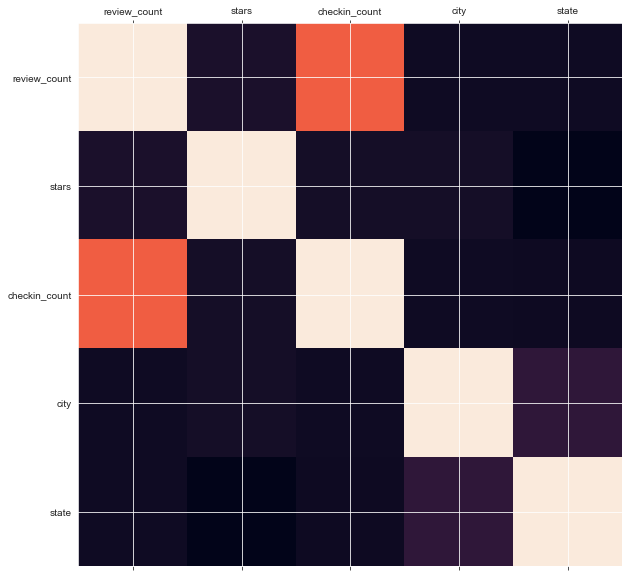

In [104]:
corr = df_merged_new.corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.show()

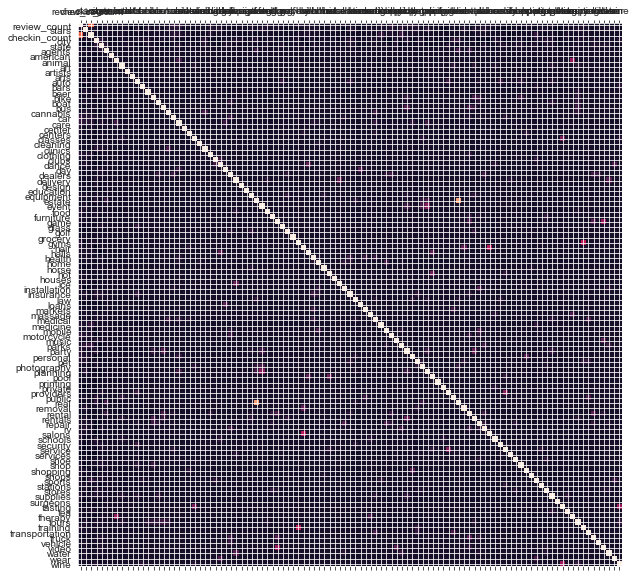

In [105]:
corr = df_merged_new_tfid.corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.show()

### Predict star ratings without using category text features

In [106]:
X = df_merged_new[['review_count', 'checkin_count', 'city', 'state']]
Y = df_merged_new['stars'].apply(int).tolist()

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 4 columns):
review_count     129268 non-null float64
checkin_count    129268 non-null float64
city             129268 non-null int64
state            129268 non-null int64
dtypes: float64(2), int64(2)
memory usage: 4.9 MB


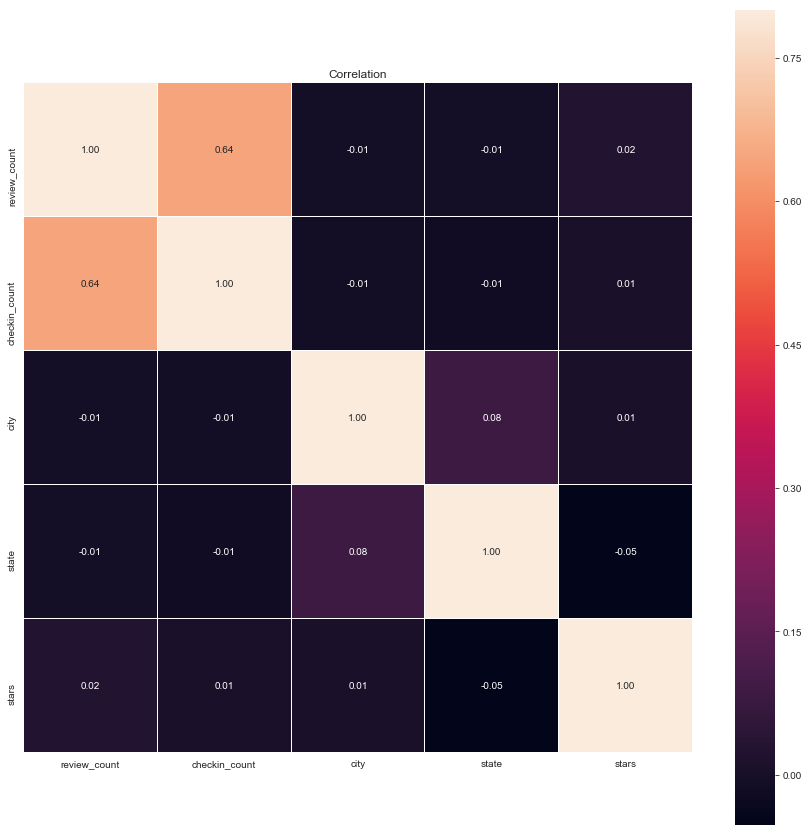

In [108]:
plt.figure(figsize=(15, 15))
ax = sns.heatmap(df_merged_new[['review_count', 'checkin_count', 'city', 'state', 'stars']].corr(), 
                 vmax=.8, square=True, fmt='.2f', annot=True, linecolor='white', linewidths=0.01)
plt.title('Correlation')
plt.show()

In [109]:
df_merged_new['stars'].value_counts()

4    71892
5    19854
2    19047
3    17020
1     1455
Name: stars, dtype: int64

In [110]:
X.shape

(129268, 4)

In [111]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

#scaler = StandardScaler()
#X_tfid = scaler.fit_transform(X_tfid)

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

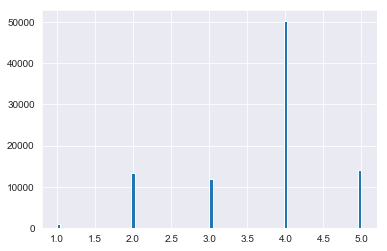

In [113]:
plt.hist(y_train, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [114]:
import collections
ctr = collections.Counter(y_train)
print("Frequency of the elements in the List : ",ctr)

Frequency of the elements in the List :  Counter({4: 50345, 5: 13988, 2: 13253, 3: 11891, 1: 1010})


From the plots, it shows that the numbers of samples of each class are imbalanced. We have only 1010 samples with 1 star. We have 50345 samples with 4 stars.

In [115]:
X_tfid = df_merged_new_tfid[['review_count', 'checkin_count', 'city', 'state'] + vectorizer.get_feature_names()]

X_tfid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Columns: 104 entries, review_count to wine
dtypes: float64(102), int64(2)
memory usage: 103.6 MB


In [116]:
X_tfid.columns

Index(['review_count', 'checkin_count', 'city', 'state', 'agents', 'american',
       'animal', 'art', 'artists', 'arts',
       ...
       'therapy', 'tours', 'training', 'transportation', 'truck', 'vehicle',
       'video', 'water', 'wear', 'wine'],
      dtype='object', length=104)

In [119]:
X_tfid['tours'].describe()

count   1279.000
mean       0.009
std        0.088
min        0.000
25%        0.000
50%        0.000
75%        0.000
max        1.000
Name: tours, dtype: float64

In [120]:
X_tfid.fillna(0, inplace=True)

In [121]:
X_train_tfid, X_test_tfid, y_train, y_test = train_test_split(X_tfid, Y, test_size=0.3, random_state=42)

- Evaluating

**Reference**

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html


https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/

https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

In [122]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
random_forest.fit(X_train, y_train)

y_predict = random_forest.predict(X_test)

predictions = [round(value) for value in y_predict]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('accuracy: {}'.format(round(accuracy, 3)))

print(f1_score(y_test, y_predict, average='macro'))  
print(f1_score(y_test, y_predict, average='micro'))
print(f1_score(y_test, y_predict, average='weighted'))  
print(f1_score(y_test, y_predict, average=None))

pd.DataFrame(confusion_matrix(y_test, y_predict))

print(classification_report(y_test, y_predict))

accuracy: 0.568
0.2102725382723511
0.5675975348753255
0.4496985157614874
[0.         0.         0.         0.71886133 0.33250136]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       445
           2       0.00      0.00      0.00      5794
           3       0.00      0.00      0.00      5129
           4       0.58      0.95      0.72     21547
           5       0.46      0.26      0.33      5866

   micro avg       0.57      0.57      0.57     38781
   macro avg       0.21      0.24      0.21     38781
weighted avg       0.39      0.57      0.45     38781



In [123]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
random_forest.fit(X_train_tfid.values, y_train)

y_predict_tfid = random_forest.predict(X_test_tfid)

predictions = [round(value) for value in y_predict_tfid]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('accuracy: {}'.format(round(accuracy, 3)))

print(f1_score(y_test, y_predict_tfid, average='macro'))  
print(f1_score(y_test, y_predict_tfid, average='micro'))
print(f1_score(y_test, y_predict_tfid, average='weighted'))  
print(f1_score(y_test, y_predict_tfid, average=None))

pd.DataFrame(confusion_matrix(y_test, y_predict_tfid))

print(classification_report(y_test, y_predict_tfid))

accuracy: 0.556
0.14286566768333114
0.5556071272014647
0.39688591598627365
[0.         0.         0.         0.71432834 0.        ]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       445
           2       0.00      0.00      0.00      5794
           3       0.00      0.00      0.00      5129
           4       0.56      1.00      0.71     21547
           5       0.00      0.00      0.00      5866

   micro avg       0.56      0.56      0.56     38781
   macro avg       0.11      0.20      0.14     38781
weighted avg       0.31      0.56      0.40     38781



In [66]:
!pip install xgboost
!pip install hyperopt

    100% |████████████████████████████████| 114.0MB 114kB/s eta 0:00:01 3% |█▎                              | 4.4MB 11.2MB/s eta 0:00:10    4% |█▍                              | 5.1MB 17.2MB/s eta 0:00:077MB 37.3MB/s eta 0:00:03    48% |███████████████▌                | 55.3MB 21.5MB/s eta 0:00:03    50% |████████████████▎               | 57.9MB 35.6MB/s eta 0:00:02    58% |██████████████████▋             | 66.2MB 22.3MB/s eta 0:00:03    65% |████████████████████▉           | 74.4MB 13.0MB/s eta 0:00:04███████████████████████▊       | 88.0MB 37.9MB/s eta 0:00:01    78% |█████████████████████████       | 89.1MB 19.4MB/s eta 0:00:02    79% |█████████████████████████▌      | 90.9MB 21.2MB/s eta 0:00:02    83% |██████████████████████████▊     | 95.3MB 28.0MB/s eta 0:00:01
    100% |████████████████████████████████| 122kB 1.8MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 16.1MB/s ta 0:00:01
    100% |████████████████████████████████| 419kB 3.4MB/s ta 0:00:011
    100% |███

In [124]:
import xgboost
from xgboost import XGBClassifier

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime

# hyperparameter tuning
# reference: 
# https://machinelearningmastery.com/xgboost-python-mini-course/
# https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost/code
# https://xgboost-clone.readthedocs.io/en/latest/parameter.html

def timer(start_time=None):
    # fork from https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
folds = 5
param_comb = 3

xgb_clf = XGBClassifier(silent=True)
params = {
            'n_estimators': [50, 100, 200, 500],
            'min_child_weight': [1, 5, 10],
            # 'gamma': [0.5, 1, 1.5, 2, 5],
            # 'subsample': [0.6, 0.8, 1.0],
            #'subsample': [0.6, 0.8, 1],
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            # 'colsample_bytree': [0.6, 0.8, 1],
            # 'max_depth': [3, 4, 5]
            'max_depth': [2, 4, 6],
        }

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

search = RandomizedSearchCV(xgb_clf, 
                            param_distributions=params, 
                            n_iter=param_comb, 
                            #scoring='roc_auc', # binary classification
                            scoring='accuracy',
                            #n_jobs=-1,
                            n_jobs=2,
                            cv=skf.split(X_train, y_train),
                            verbose=3, random_state=42)

# search = GridSearchCV(model, params, scoring="neg_log_loss", n_jobs=-1, cv=skf)

start_time = timer(None)
search.fit(X_train, y_train)
timer(start_time)

print('--------------')
print('\n all results:')
print(search.cv_results_)

print('\n best estimator:')
print(search.best_estimator_)

print('\n best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(search.best_score_ * 2 - 1)

print('\n best xgb hyperparameters:')
print(search.best_params_)

result_csv_path = 'xgb-search-results.csv'
results = pd.DataFrame(search.cv_results_)
results.to_csv(result_csv_path, index=False)
print('save xgb search results to {}'.format(result_csv_path))
print('--------------')

#y_pred = search.predict_proba(X_test)
#y_pred = np.argmax(y_pred)
y_pred = search.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print('accuracy: {}'.format(round(accuracy, 3)))

print(f1_score(y_test, predictions, average='macro'))  
print(f1_score(y_test, predictions, average='micro'))
print(f1_score(y_test, predictions, average='weighted'))  
print(f1_score(y_test, predictions, average=None))

conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

print(classification_report(y_test, predictions))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:  5.3min finished



 Time taken: 0 hours 5 minutes and 29.12 seconds.
--------------

 all results:
{'mean_fit_time': array([65.14639859,  9.80966144, 25.51775217]), 'std_fit_time': array([1.01050751, 0.14871239, 0.26861258]), 'mean_score_time': array([3.04054642, 0.3734097 , 1.08937922]), 'std_score_time': array([0.14591724, 0.02150901, 0.02729457]), 'param_n_estimators': masked_array(data=[500, 100, 200],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[10, 1, 1],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[6, 4, 6],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6}, {'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 4}, {'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6}], 'split0_test_score': array([0.57